In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [12]:
#### Data Visualization here

data_normal = pd.read_csv('dataset/ecg_dataset/ptbdb_normal.csv', header = None)
data_abnormal = pd.read_csv('dataset/ecg_dataset/ptbdb_abnormal.csv', header = None)
classes_names = {0 : "normal",
                 1 : "abnormal"}

num_cols = data_normal.shape[1] - 1
time = np.arange(0, num_cols) / 125
time = time * 1000
data_normal.columns = list(time) + ["label"]
data_abnormal.columns = list(time) + ["label"]
df_ptbd = pd.concat([data_normal, data_abnormal], axis = 0)
counts = df_ptbd["label"].value_counts()
counts.index = counts.index.map(classes_names)

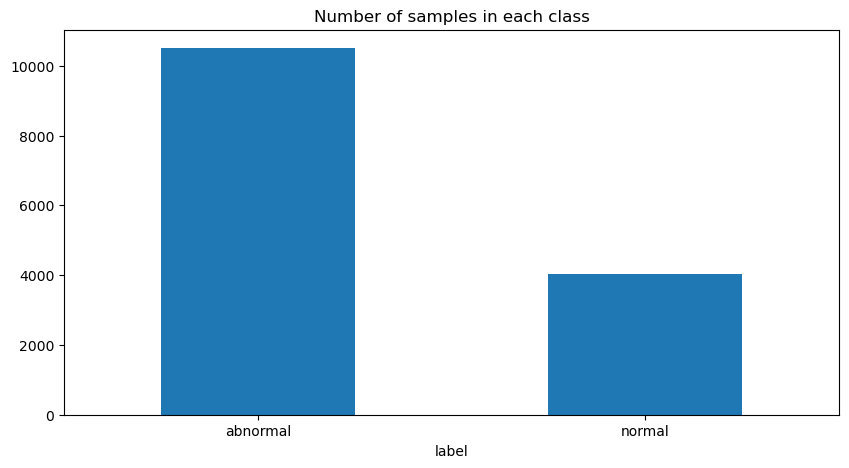

In [13]:
# create a figure
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.title("Number of samples in each class")
plt.show()
plt.close()

In [14]:
#### Data concatenation and preparation here
normal_df = pd.read_csv("dataset/ecg_dataset/ptbdb_normal.csv", header=None)
abnormal_df = pd.read_csv("dataset/ecg_dataset/ptbdb_abnormal.csv", header=None)

abnormal_df.rename(columns={'187': "Label"}, inplace=True)
normal_df.rename(columns={'187': "Label"}, inplace=True)

#downsample the abnormal df to a size closer to the normal df
abnormal_df = abnormal_df.sample(n=5000, random_state=1)
total_df = pd.concat([normal_df, abnormal_df])

len(total_df)

9046

In [ ]:
#### Model init and training here
X, y = total_df.iloc[:,:187], total_df.iloc[:,-1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators = 150, min_samples_split=5, random_state=1, bootstrap=False)
model.fit(X_train, y_train)
print("Random forest Accuracy Score:", cross_val_score(model, X, y).mean())
y_pred = model.predict(X_test)

print("Recall Score:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# model = random forest

# clf1 = XGBClassifier(n_estimators=500, base_score=0.5, booster='gbtree', missing=0, verbosity=2)
clf1 = XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=700, learning_rate=0.1, random_state=1)

# clf2 = GradientBoostingClassifier() # was above 0.9 but worse than xgboost

# models under 0.9
# clf1 = LogisticRegression(random_state=1)
# clf2 = RandomForestClassifier(n_estimators = 150, min_samples_split=5, random_state=1, bootstrap=False)
# clf3 = GaussianNB()
# clf5 = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=1)

In [ ]:
rfc = RandomForestClassifier()
param_grid = {"n_estimators":[150,175], "min_samples_split":[5,10]}
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=2, scoring="recall")
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

## Plot confusion matrix

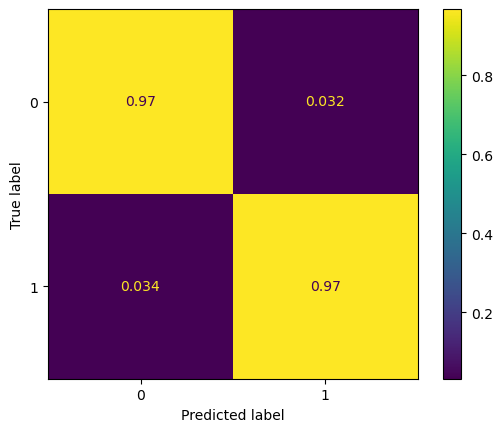

In [37]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Ensemble voting classifier and accuracy scores

In [39]:
eclf = VotingClassifier(
    # estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('gb', clf4), ('ada', clf5)],
    estimators = [('rf', model), ('xgb', clf1), ('gs', grid_search)],
    voting='hard')

# for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Gradient Boosting', 'ADA Boosting', 'Ensemble']):
for clf, label in zip([model, clf1, grid_search, eclf], ['RandomForest', 'xgBoost', 'GridSearch', 'Ensemble']):
    scores = cross_val_score(clf, X, y.values.ravel(), scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Scores: [0.96906077 0.96572692 0.96627971 0.97567717 0.96849088]
Accuracy: 0.97 (+/- 0.00) [RandomForest]
Scores: [0.96519337 0.97457159 0.97401879 0.97070205 0.97512438]
Accuracy: 0.97 (+/- 0.00) [xgBoost]
Scores: [0.96022099 0.95301271 0.95688226 0.9673853  0.96296296]
Accuracy: 0.96 (+/- 0.00) [GridSearch]
Scores: [0.96740331 0.9668325  0.96517413 0.97236042 0.97014925]
Accuracy: 0.97 (+/- 0.00) [Ensemble]


In [91]:
eclf = VotingClassifier(
    # estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('gb', clf4), ('ada', clf5)],
    estimators = [('rf', model), ('xgb', clf1), ('gs', grid_search)],
    voting='soft')

# for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Gradient Boosting', 'ADA Boosting', 'Ensemble']):
for clf, label in zip([model, clf1, grid_search, eclf], ['RandomForest', 'xgBoost', 'GridSearch', 'Ensemble']):
    scores = cross_val_score(clf, X, y.values.ravel(), scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.97 (+/- 0.00) [RandomForest]
Accuracy: 0.97 (+/- 0.00) [xgBoost]
Accuracy: 0.96 (+/- 0.01) [GridSearch]
Accuracy: 0.97 (+/- 0.00) [Ensemble]


## Plot

Random Forest Score: 96.74%
xgBoost Score: 97.29%
Grid Search Score: 97.51%
Ensemble Score: 97.46%


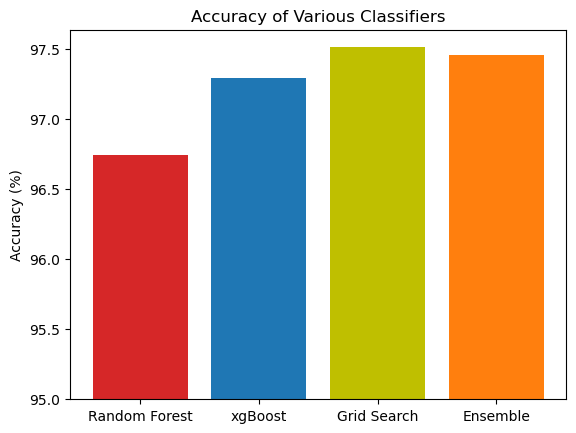

In [92]:
names = ['Random Forest', 'xgBoost', 'Grid Search', 'Ensemble']
floatScores = [0.0, 0.0, 0.0, 0.0]
base = 95

for i in range(0,4):
    print(f'{names[i]} Score: {(100*scores[i]):.2f}%')
    floatScores[i] = float(scores[i]*100) - 95
fig, ax = plt.subplots()

# bar_labels = ['red', 'blue', 'yellow', 'orange']
bar_colors = ['tab:red', 'tab:blue', 'y', 'tab:orange']

# ax.bar(names, floatScores, label=bar_labels, color=bar_colors, bottom=base)
ax.bar(names, floatScores, color=bar_colors, bottom=base)

ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy of Various Classifiers')
# ax.legend(title='color')

plt.show()